# Gumbel Softmax VAE

This notebook is intended for loading and exploring arbitrary pre-trained models

In [1]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)


# Settings

In [3]:
SAVE_NAME = 'gsvae.labeled'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'


TEST_SIZE = 1000
EPOCHS = 50
LR = 1e-03
BATCH_SIZE = 32

TEMPERATURE = 1


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Dataset

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: pallets_labels.json


In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Training

In [8]:
input_dim = 222 * 24 * 24
hidden_dim = 128
latent_dim = 32
classes_dim = len(dataset._label_keys)  # 92


In [9]:
model = M.gumbel.LabeledGSVAE(
    input_dim, hidden_dim, latent_dim, classes_dim, TEMPERATURE
)
criterion = M.gumbel.Loss()

train_losses, test_losses = M.gumbel.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, with_labels=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)


INFO | model: pallets.models.gumbel.LabeledGSVAE
INFO | criterion: pallets.models.gumbel.Loss
INFO | learn rate: 0.001
INFO | epochs: 50
INFO | epoch 1 (  0%) loss: 1419241.875000
INFO | epoch 1 ( 35%) loss: 258467.555422
INFO | epoch 1 ( 70%) loss: 135705.091204
INFO | epoch 1 (100%) loss: 99979.637431
INFO | epoch 1 (test) loss: 11156.620026
INFO | epoch 2 (  0%) loss: 10660.712891
INFO | epoch 2 ( 35%) loss: 11339.612517
INFO | epoch 2 ( 70%) loss: 11307.118805
INFO | epoch 2 (100%) loss: 11252.291447
INFO | epoch 2 (test) loss: 11047.788788
INFO | epoch 3 (  0%) loss: 10925.098633
INFO | epoch 3 ( 35%) loss: 11179.087871
INFO | epoch 3 ( 70%) loss: 11190.389221
INFO | epoch 3 (100%) loss: 11158.073227
INFO | epoch 3 (test) loss: 10988.958115
INFO | epoch 4 (  0%) loss: 11361.206055
INFO | epoch 4 ( 35%) loss: 11156.276648
INFO | epoch 4 ( 70%) loss: 11128.152528
INFO | epoch 4 (100%) loss: 11070.894806
INFO | epoch 4 (test) loss: 10817.397125
INFO | epoch 5 (  0%) loss: 11084.06543

# Results

## Random Inputs

In [10]:
import random

def rand_label():
    label_idx = int(random.random() * len(dataset._labels))
    features = dataset._labels[label_idx]
    enabled_names = [k for k,v in zip(dataset._label_keys, features) if v.item() == 1]
    return features.to(device), enabled_names


In [11]:
def rand_punk():
    z = torch.randn(1, latent_dim*classes_dim).to(device)
    # print(z.shape)

    with torch.no_grad():
        model.eval()
        generated_image = model.decoder(z)
        # print(generated_image.shape)

    decoded_one_hot = generated_image[0].view((222, 24, 24))
    # print(decoded_one_hot.shape)

    decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
    # print(decoded.shape)
    return decoded



### 5 Randoms

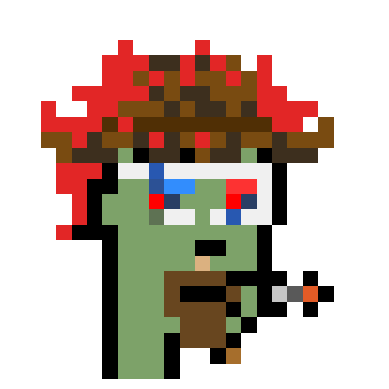

In [12]:
decoded = rand_punk()
plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


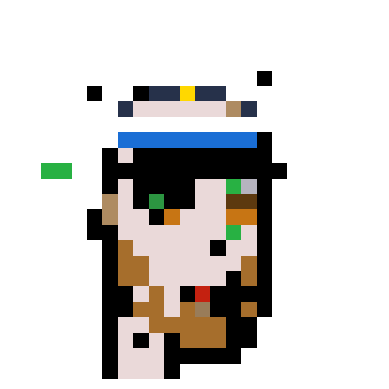

In [13]:
decoded = rand_punk()
plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


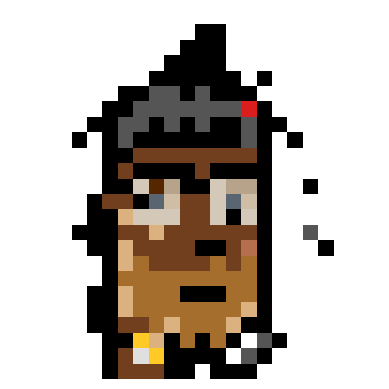

In [14]:
decoded = rand_punk()
plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


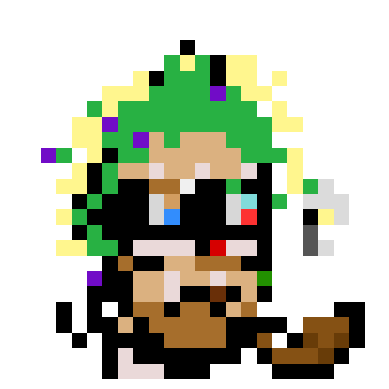

In [15]:
decoded = rand_punk()
plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


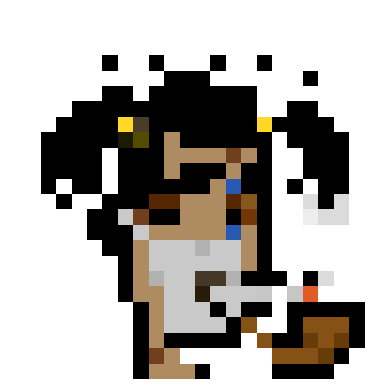

In [16]:
decoded = rand_punk()
plt.imshow(to_pil_image(decoded))
plt.axis('off')
plt.show()


## Reconstruction

In [17]:
def reconstruct_punk(idx):
    punk = I.get_punk_tensor(idx)
    p = DS.rgba_to_one_hot(punk, dataset.mapper)
    p = p.unsqueeze(0)
    p = p.to(device)

    _, labels = dataset[idx]
    l = labels.unsqueeze(0)
    l = l.to(device)
    enabled_features = [k for k,v in zip(dataset._label_keys, labels) if v.item() == 1]

    model.eval()
    with torch.no_grad():
        reconstructed, x_y = model.forward(p, l)

    recon_punk = reconstructed[0].cpu()
    recon_punk = recon_punk.view((222, 24, 24))
    recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)

    return punk, recon_punk, enabled_features


def draw_two(img1, img2):
    page_size = 2
    view_x, view_y = 4*page_size, 2*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(1, 2, 1)
    plt.imshow(to_pil_image(img1))
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(to_pil_image(img2))
    plt.axis('off')
    plt.show()


### 5 Reconstructions

Features: female, rosyCheeks, darkHair, cigarette


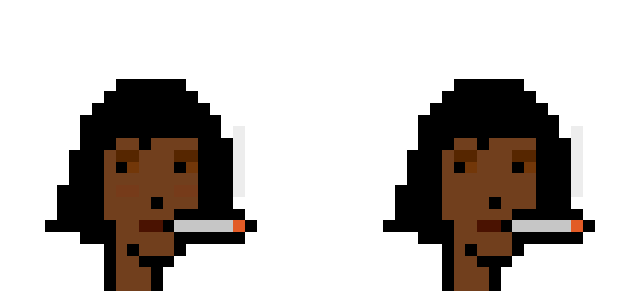

In [18]:
punk, recon_punk, features = reconstruct_punk(1000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: female, stringyHair, purpleLipstick, earring


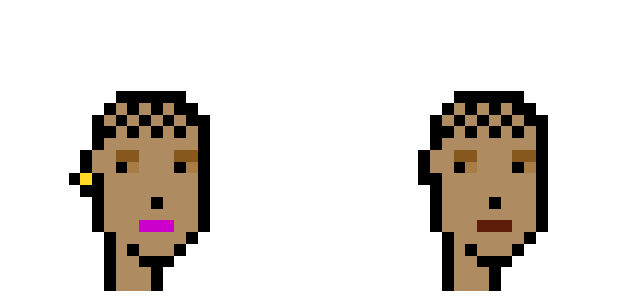

In [19]:
punk, recon_punk, features = reconstruct_punk(2001)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)


Features: female, wildWhiteHair, greenEyeShadow, hotLipstick


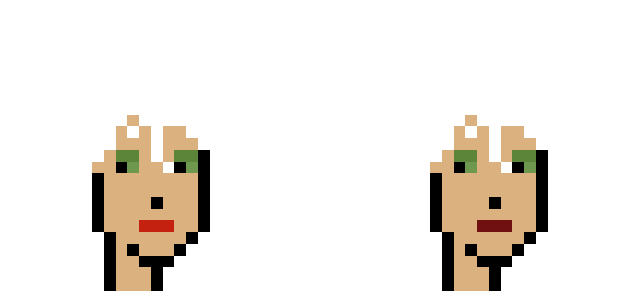

In [20]:
punk, recon_punk, features = reconstruct_punk(5000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, rosyCheeks, mustache, vr, cap, cigarette


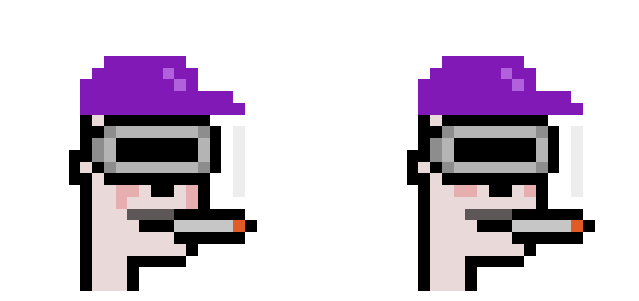

In [21]:
punk, recon_punk, features = reconstruct_punk(8000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, handlebars, bandana


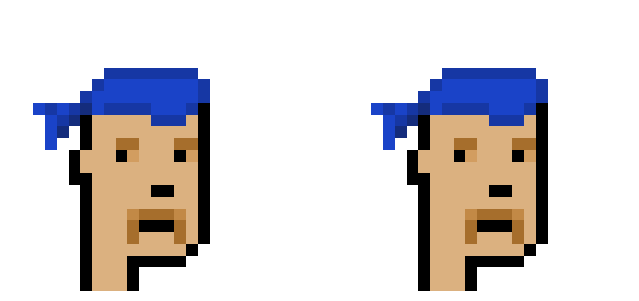

In [22]:
punk, recon_punk, features = reconstruct_punk(1337)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

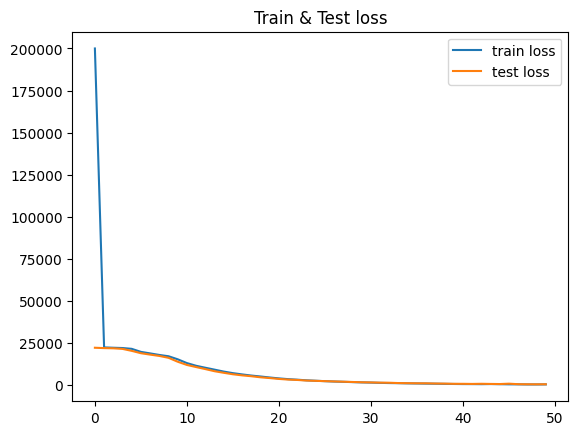

In [23]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [24]:
train_losses

[199959.2748625194,
 22504.58289353391,
 22316.14645320811,
 22141.789611383534,
 21661.600646539784,
 19863.291571434507,
 18957.053891012856,
 18035.54906533965,
 17262.261149954287,
 15452.416459753158,
 13200.382234181072,
 11608.598651858932,
 10440.689094705785,
 9314.113941814883,
 8166.036316350842,
 7228.769003577267,
 6480.224655692459,
 5803.130710466534,
 5248.2920774635695,
 4651.845864153923,
 4119.141358287622,
 3673.4405550043634,
 3348.2955657742546,
 2968.806557513298,
 2722.860504366827,
 2474.824845983627,
 2246.8207583596522,
 2092.779311809134,
 1909.2255963264627,
 1739.510260724007,
 1623.0722281814467,
 1458.5820598196476,
 1351.136242697425,
 1276.575794734008,
 1160.3420262438185,
 1096.4384358723958,
 1016.3292398114577,
 955.4256267141789,
 863.2214119011629,
 805.7099677552568,
 747.6463303802707,
 728.1667864102844,
 688.7025161634946,
 759.6006595259862,
 675.7987315401118,
 592.6205452993406,
 574.5632843666888,
 506.54079523830546,
 507.2208254658584,


In [25]:
test_losses

[22313.24005126953,
 22095.577575683594,
 21977.916229248047,
 21634.79425048828,
 20465.92527770996,
 19069.879272460938,
 18237.857482910156,
 17450.775230407715,
 16341.928451538086,
 14010.329536437988,
 12096.769676208496,
 10848.883270263672,
 9643.837379455566,
 8380.790306091309,
 7440.446159362793,
 6570.188938140869,
 5916.381324768066,
 5406.749599456787,
 4766.916011810303,
 4314.001365661621,
 3799.05269241333,
 3420.122064590454,
 3188.733169555664,
 2844.1427612304688,
 2662.4002113342285,
 2481.593307495117,
 2315.4036827087402,
 2149.7735080718994,
 1984.3399257659912,
 1814.294439315796,
 1715.6016855239868,
 1590.1149854660034,
 1534.913724899292,
 1341.322244644165,
 1275.099202156067,
 1206.6752610206604,
 1192.9436283111572,
 1067.6308403015137,
 1017.4646096229553,
 893.8941287994385,
 896.4039359092712,
 828.4852743148804,
 914.0027747154236,
 824.8819265365601,
 761.7724571228027,
 978.6004819869995,
 673.7773218154907,
 623.3938264846802,
 600.6089553833008,
 